<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:
!pip install torchvision==0.1.9
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.backends.cudnn.benchmark=True

In [0]:
PATH = "/content/gdrive/My Drive/ImageEnhancement/"

In [0]:
PATH = Path('/content/gdrive/My Drive/ImageEnhancement')
PATH_TRN = PATH/'train'

In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [0]:
img_fn = PATH_TRN/'n01440764'/'20200102_214655.jpg'
img = open_image(img_fn)
img = np.rot90(img, k=1, axes=(0, 1))

In [0]:
sz=288

In [31]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

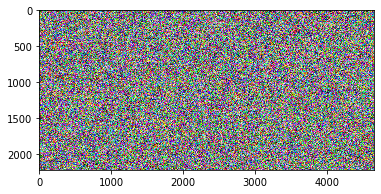

In [32]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

In [0]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

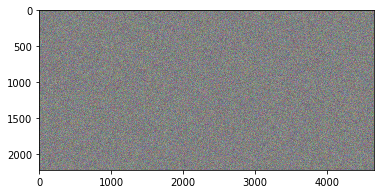

In [34]:
plt.imshow(opt_img)

In [35]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [0]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [37]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [0]:

max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [0]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [41]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.748206615447998
Iteration: 200, loss: 0.3693416118621826
Iteration: 300, loss: 0.25543177127838135
Iteration: 400, loss: 0.20098000764846802
Iteration: 500, loss: 0.1702723354101181
Iteration: 600, loss: 0.1510087102651596
Iteration: 700, loss: 0.13764004409313202
Iteration: 800, loss: 0.12787416577339172
Iteration: 900, loss: 0.12016670405864716
Iteration: 1000, loss: 0.1137114018201828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


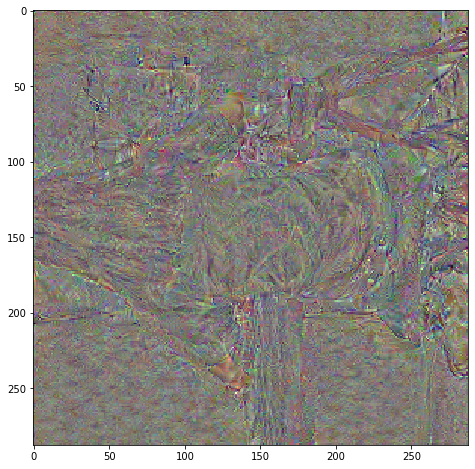

In [42]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(8,8))
plt.imshow(x)

forward hook

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [45]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [0]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [0]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [0]:
opt_img_v, optimizer = get_opt()

In [49]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [0]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [51]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.2691255211830139
Iteration: 200, loss: 0.1308095008134842
Iteration: 300, loss: 0.09031452983617783
Iteration: 400, loss: 0.0707264319062233
Iteration: 500, loss: 0.0587773323059082
Iteration: 600, loss: 0.05115310102701187
Iteration: 700, loss: 0.04570218548178673
Iteration: 800, loss: 0.041617557406425476
Iteration: 900, loss: 0.03840670734643936
Iteration: 1000, loss: 0.03583458438515663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


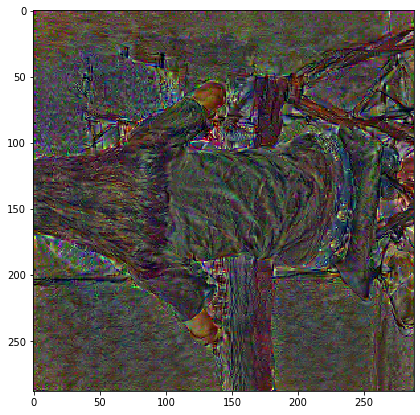

In [52]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);